In [2]:
%load_ext autoreload
%autoreload 2
from biometric_system import BiometricSystem
from anomaly_detectors.M2005 import M2005 
from anomaly_detectors import thresholds
from data_stream import data_stream
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold


import ipdb
import os, sys
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import random
import copy
import IPython.display as ipd
        
def Average(lst):
    x = sum(lst)
    y = len(lst)
    a = (round(x,6) / round(y))
    return a


def split_data_enrollment(dataset, column, n_samples):
    data_to_enrollment = dict()

    for value in dataset[column].unique():
        
        data_to_enrollment.setdefault(value, dataset.loc[dataset[column]==value].iloc[:(n_samples//2)].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))
    
    return data_to_enrollment

def split_data_validation(dataset, column, n_samples):
    data_to_validation = dict()

    for value in dataset[column].unique():
        
        data_to_validation.setdefault(value, dataset.loc[dataset[column]==value].iloc[(n_samples//2):n_samples].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))
    
    return data_to_validation


def split_data_recognition(dataset, column, n_samples):
    data_to_recognition = dict()

    for value in dataset[column].unique():
 
        data_to_recognition.setdefault(value, dataset.loc[dataset[column]==value].iloc[:n_samples].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))
    
    
    return data_to_recognition

def split_data(dataset, column, n_samples):
    data_to_enrollment = dict()
    data_to_validation = dict()
    data_to_recognition = dict()

    for value in dataset[column].unique():
        
        #Treinamento, pegando dados de usuarios 
        data_to_enrollment.setdefault(value, dataset.loc[dataset[column]==value].iloc[:(n_samples//2)].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))

        # Definir o limiar de decisao dos algoritmos de classificacao
        data_to_validation.setdefault(value, dataset.loc[dataset[column]==value].iloc[(n_samples//2):n_samples].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))

        # Criar o fluxo de teste
        data_to_recognition.setdefault(value, dataset.loc[dataset[column]==value].iloc[n_samples:].loc[:,~dataset.columns.isin([column])].reset_index(drop=True))
    
    
    return data_to_enrollment,data_to_validation, data_to_recognition


# Supondo que você tenha um DataFrame chamado 'dados' com uma coluna 'subject' para os usuários
dados = pd.read_excel('dados/Greyc.xlsx')

# DataFrame para armazenar as 60 primeiras amostras de cada usuário que tem pelo menos 60 amostras
df = pd.DataFrame()

# Lista para armazenar os usuários que têm pelo menos 60 amostras e foram utilizados para criar o DataFrame
users = []

for usuario in dados['subject'].unique():
    # Verificar se o usuário tem pelo menos 60 amostras
    if dados[dados['subject'] == usuario].shape[0] >= 60:
        # Selecionar as 60 primeiras amostras do usuário atual
        amostras_usuario = dados[dados['subject'] == usuario].head(60)
        
        # Adicionar as amostras ao DataFrame principal
        df = pd.concat([df, amostras_usuario])
        
        # Adicionar o usuário à lista de usuários utilizados
        users.append(usuario)


FALSE = []
SLIDING = []
GROWING = []
DOUBLEPARALEL = []



#--------------------------------------------------------------------------------------------------------------#  
#Parametros

R = 1
perc = 0.5
impostor_rate = 0.30
rate_external_impostor = 0

#--------------------------------------------------------------------------------------------------------------# 
#Separação de index, primeiro pra treino, segundo para validação e teste
# Dependendo do teste é necessario trocar a linha 43 ("Separação por Index")

sessionIndex1 = 1
# usando !sessionIndex1, estou usando todas as outras sessoes

#--------------------------------------------------------------------------------------------------------------# 
#Separação de usuarios

len_reg_users = int(len(users) * perc)

kfold = KFold(n_splits=2, shuffle=True, random_state=R)
splits = kfold.split(users)

#--------------------------------------------------------------------------------------------------------------# 
#Separação de usuarios
# Convertendo a lista de usuários para um numpy array
users_array = np.array(users)

for i, (reg_users, not_reg_users) in enumerate(splits):
    # Convertendo os índices reg_users para um numpy array
    reg_users_array = np.array(reg_users)
    
    # Usando os índices reg_users para indexar o array de usuários
    internal_users = copy.deepcopy(df.loc[df['subject'].isin(users_array[reg_users_array])])
    external_users = copy.deepcopy(df.loc[~df['subject'].isin(users_array[reg_users_array])])

#--------------------------------------------------------------------------------------------------------------#  
#Separação por Index

dataS1 = internal_users.loc[(internal_users['sessionIndex'] == sessionIndex1)]
dataS2 = internal_users.loc[(internal_users['sessionIndex'] != sessionIndex1)]


#--------------------------------------------------------------------------------------------------------------#  
# Dados para Treino, Validação e Reconhecimento

#Treinamento, pegando dados de usuarios 
data_to_enrollment = split_data_enrollment(dataS1, column='subject', n_samples=10)

# Definir o limiar de decisao dos algoritmos de classificacao
data_to_validation = split_data_validation(dataS1, column='subject', n_samples=10)

# Criar o fluxo de teste
data_to_recognition = split_data_recognition(dataS2, column='subject', n_samples=50)

_, _, external_users_data = split_data(external_users, column='subject', n_samples=10)

#--------------------------------------------------------------------------------------------------------------# 
#Sistema sem Adaptação (False)

detector = M2005()
adaptive = "False"
system = BiometricSystem(detector=detector, random_state=R)
system.enrollment(dataset=data_to_enrollment, adaptive=adaptive)

decision_threshold = thresholds.best_threshold(data_to_validation, system, size=10, random_state=R)

metrics = dict()
auxiliar0 = {}

lista_nao_usadas_false = list()
lista_usadas_false = list()
lista_adaptacao_false = list()



for j, genuine in enumerate(system.users.keys()):

    ipd.clear_output(wait=True)
    print(f"Rodando False:{R}")
    print(f"Testando usuário {j+1}/{len(system.users.keys())}")


    datastream = data_stream.Random(impostor_rate= impostor_rate, rate_external_impostor=rate_external_impostor, random_state=R)

    test_stream, y_true, amostras_noadaptative_genuinas, amostras_noadaptative_impostoras = datastream.create(genuine, data_to_recognition, external_users_data)


    y_pred, lista_nao_usadas_false, lista_usadas_false,lista_adaptacao_false  = system.autenticate(genuine, test_stream, decision_threshold=decision_threshold, adaptive_TESTE=adaptive, return_scores=False)
    
    fmr, fnmr, b_acc, y_genuine , y_impostor = system.compute_metrics(y_true, y_pred)
    
    auxiliar0[genuine] = y_genuine.value_counts()[1], y_impostor.value_counts()[0]


    for met in ['fmr','fnmr','b_acc']:
        metrics.setdefault(genuine, dict()).setdefault(met,[]).append(eval(met))


usuarios = metrics.keys()
result = pd.DataFrame(metrics.values())

fmr_mean = []
fnmr_mean = []
b_acc_mean = []

for i in result['fmr']:
    fmr_mean.append(Average(i))

for i in result['fnmr']:
    fnmr_mean.append(Average(i))

for i in result['b_acc']:
    b_acc_mean.append(Average(i))

metrics_mean = pd.DataFrame(list(zip(usuarios, fmr_mean, fnmr_mean,b_acc_mean)),
               columns =['Usuarios','fmr_mean', 'fnmr_mean','b_acc_mean'])
FALSE.append(metrics_mean['b_acc_mean'].mean())


#--------------------------------------------------------------------------------------------------------------# 
#Sistema com Adaptação (SlidingWindow)

detector = M2005()
adaptive= "SlidingWindow"
system = BiometricSystem(detector=detector, random_state=R)
system.enrollment(dataset=data_to_enrollment, adaptive=adaptive)

decision_threshold = thresholds.best_threshold(data_to_validation, system, size=10, random_state=R)

metrics_adaptativo_sliding = dict()
auxiliar1 = {}

lista_nao_usadas_sliding = list()
lista_usadas_sliding = list()
lista_adaptacao_sliding = list()


for j, genuine in enumerate(system.users.keys()):


    ipd.clear_output(wait=True)
    print(f"Rodando Sliding:{R}")
    print(f"Testando usuário {j+1}/{len(system.users.keys())}")

    datastream = data_stream.Random(impostor_rate= impostor_rate, rate_external_impostor=rate_external_impostor, random_state=R)
    test_stream, y_true,amostras_sliding_genuinas,amostras_sliding_impostoras = datastream.create(genuine, data_to_recognition, external_users_data)

    #import pdb 
    #pdb.set_trace()

    y_pred, lista_nao_usadas_sliding2, lista_usadas_sliding2,lista_adaptacao_sliding = system.autenticate(genuine, test_stream, decision_threshold=decision_threshold, adaptive_TESTE=adaptive, return_scores=False)

    lista_nao_usadas_sliding.append(lista_nao_usadas_sliding2)
    lista_usadas_sliding.append(lista_usadas_sliding2)

    fmr, fnmr, b_acc, y_genuine , y_impostor = system.compute_metrics(y_true, y_pred)
    
    auxiliar1[genuine] = y_genuine.value_counts()[1], y_impostor.value_counts()[0]

    for met in ['fmr','fnmr','b_acc']:
        metrics_adaptativo_sliding.setdefault(genuine, dict()).setdefault(met,[]).append(eval(met))

usuarios = metrics_adaptativo_sliding.keys()
result = pd.DataFrame(metrics_adaptativo_sliding.values())

fmr_mean = []
fnmr_mean = []
b_acc_mean = []

for i in result['fmr']:
    fmr_mean.append(Average(i))

for i in result['fnmr']:
    fnmr_mean.append(Average(i))

for i in result['b_acc']:
    b_acc_mean.append(Average(i))

metrics_adaptativo_sliding_mean = pd.DataFrame(list(zip(usuarios, fmr_mean, fnmr_mean,b_acc_mean)),
               columns =['Usuarios','fmr_mean', 'fnmr_mean','b_acc_mean'])

SLIDING.append(metrics_adaptativo_sliding_mean['b_acc_mean'].mean())


#--------------------------------------------------------------------------------------------------------------#  
#Sistema com Adaptação (GrowingWindow)

detector = M2005()
adaptive= 'GrowingWindow'
system = BiometricSystem(detector=detector, random_state=R)
system.enrollment(dataset=data_to_enrollment, adaptive=adaptive)

decision_threshold = thresholds.best_threshold(data_to_validation, system, size=10, random_state=R)

metrics_adaptativo_growing = dict()
auxiliar_growing = {}

lista_nao_usadas_growing = list()
lista_usadas_growing = list()
lista_adaptacao_growing = ()

for j, genuine in enumerate(system.users.keys()):

    ipd.clear_output(wait=True)
    print(f"Rodando Growing:{R}")
    print(f"Testando usuário {j+1}/{len(system.users.keys())}")

    datastream = data_stream.Random(impostor_rate= impostor_rate, rate_external_impostor=rate_external_impostor, random_state=R)
    test_stream, y_true,amostras_growing_genuinas,amostras_growing_impostoras = datastream.create(genuine, data_to_recognition, external_users_data)

    y_pred, lista_nao_usadas_growing2, lista_usadas_growing2,lista_adaptacao_growing = system.autenticate(genuine, test_stream, decision_threshold=decision_threshold, adaptive_TESTE=adaptive, return_scores=False)

    lista_nao_usadas_growing.append(lista_nao_usadas_growing2)
    lista_usadas_growing.append(lista_usadas_growing2)
    
    fmr, fnmr, b_acc, clas_genuine_growing , clas_impostor_growing= system.compute_metrics(y_true, y_pred)
            
    auxiliar_growing[genuine] = clas_genuine_growing.value_counts()[1], clas_impostor_growing.value_counts()[0]

    for met in ['fmr','fnmr','b_acc']:
        metrics_adaptativo_growing.setdefault(genuine, dict()).setdefault(met,[]).append(eval(met))

usuarios = metrics_adaptativo_growing.keys()    
result = pd.DataFrame(metrics_adaptativo_growing.values())

fmr_mean = []
fnmr_mean = []
b_acc_mean = []

for i in result['fmr']:
    fmr_mean.append(Average(i))

for i in result['fnmr']:
    fnmr_mean.append(Average(i))

for i in result['b_acc']:
    b_acc_mean.append(Average(i))

metrics_adaptativo_growing_mean = pd.DataFrame(list(zip(usuarios, fmr_mean, fnmr_mean,b_acc_mean)),
               columns =['Usuarios','fmr_mean', 'fnmr_mean','b_acc_mean'])

GROWING.append(metrics_adaptativo_growing_mean['b_acc_mean'].mean())

#--------------------------------------------------------------------------------------------------------------# 
#Sistema com Adaptação (DoubleParallel)
detector = M2005()
adaptive= 'DoubleParallel'
system = BiometricSystem(detector=detector, random_state=R)
system.enrollment(dataset=data_to_enrollment, adaptive=adaptive)

decision_threshold = thresholds.best_threshold(data_to_validation, system, size=10, random_state=R)

metrics_adaptativo_double = dict()
auxiliar_double = {}

lista_nao_usadas_double = list()
lista_usadas_double = list()
lista_adaptacao_double = list()

for j, genuine in enumerate(system.users.keys()):

    ipd.clear_output(wait=True)
    print(f"Rodando Double:{R}")
    print(f"Testando usuário {j+1}/{len(system.users.keys())}")

    datastream = data_stream.Random(impostor_rate= impostor_rate, rate_external_impostor=rate_external_impostor, random_state=R)
    test_stream, y_true,amostras_double_genuinas,amostras_double_impostoras = datastream.create(genuine, data_to_recognition, external_users_data)


    y_pred, lista_nao_usadas_double2, lista_usadas_double2,lista_adaptacao_double = system.autenticate(genuine, test_stream, decision_threshold=decision_threshold,adaptive_TESTE=adaptive, return_scores=False)

    lista_nao_usadas_double.append(lista_nao_usadas_double2)
    lista_usadas_double.append(lista_usadas_double2)

    fmr, fnmr, b_acc,  clas_genuine_double , clas_impostor_double = system.compute_metrics(y_true, y_pred)
        

    auxiliar_double[genuine] = clas_genuine_double.value_counts()[1], clas_impostor_double.value_counts()[0]

    for met in ['fmr','fnmr','b_acc']:
        metrics_adaptativo_double.setdefault(genuine, dict()).setdefault(met,[]).append(eval(met))


usuarios = metrics_adaptativo_double.keys()    
result = pd.DataFrame(metrics_adaptativo_double.values())

fmr_mean = []
fnmr_mean = []
b_acc_mean = []

for i in result['fmr']:
    fmr_mean.append(Average(i))

for i in result['fnmr']:
    fnmr_mean.append(Average(i))

for i in result['b_acc']:
    b_acc_mean.append(Average(i))

metrics_adaptativo_double_mean = pd.DataFrame(list(zip(usuarios, fmr_mean, fnmr_mean,b_acc_mean)),
               columns =['Usuarios','fmr_mean', 'fnmr_mean','b_acc_mean'])

DOUBLEPARALEL.append(metrics_adaptativo_double_mean['b_acc_mean'].mean())
#------------------------------------------------------------------------------------------
print('---------------------')
print("Teste com Randon State", R)

print("valor de False: {:.2f}%".format(FALSE[0]))
print("valor de Sliding: {:.2f}%".format(SLIDING[0]))
print("valor de Growing: {:.2f}%".format(GROWING[0]))

print("valor de Double Paralell: {:.2f}%".format(DOUBLEPARALEL[0]))




Rodando Double:1
Testando usuário 50/50
---------------------
Teste com Randon State 1
valor de False: 0.79%
valor de Sliding: 0.90%
valor de Growing: 0.76%
valor de Double Paralell: 0.87%


In [5]:
print('False')
print("Bacc de False: {:}%".format(FALSE[0]))
print("Valor de FMR: {:}%".format(metrics_mean['fmr_mean'].mean()))
print("Valor de FNMR: {:}%".format(metrics_mean['fnmr_mean'].mean()))
print('----------------------------------------')
print('Sliding Window')
print("Bacc de Sliding: {:}%".format(SLIDING[0]))
print('Valor de FMR: {:}%'.format(metrics_adaptativo_sliding_mean['fmr_mean'].mean()))
print('Valor de FNMR: {:}%'.format(metrics_adaptativo_sliding_mean['fnmr_mean'].mean()))
print('----------------------------------------')
print('Growing Window')
print("Bacc de Growing: {:}%".format(GROWING[0]))
print('Valor de FMR: {:}%'.format(metrics_adaptativo_growing_mean['fmr_mean'].mean()))
print('Valor de FNMR: {:}%'.format(metrics_adaptativo_growing_mean['fnmr_mean'].mean()))
print('----------------------------------------')
print('Double Paralel')
print("Bacc de Growing: {:}%".format(DOUBLEPARALEL[0]))
print('Valor de FMR: {:}%'.format(metrics_adaptativo_double_mean['fmr_mean'].mean()))
print('Valor de FNMR: {:}%'.format(metrics_adaptativo_double_mean['fnmr_mean'].mean()))

False
Bacc de False: 0.7925029199999998%
Valor de FMR: 0.16210536%
Valor de FNMR: 0.25288886%
----------------------------------------
Sliding Window
Bacc de Sliding: 0.9013567999999998%
Valor de FMR: 0.07684219999999999%
Valor de FNMR: 0.12044442%
----------------------------------------
Growing Window
Bacc de Growing: 0.7599064600000003%
Valor de FMR: 0.4526315999999999%
Valor de FNMR: 0.027555519999999997%
----------------------------------------
Double Paralel
Bacc de Growing: 0.8654035999999996%
Valor de FMR: 0.23052633999999994%
Valor de FNMR: 0.03866651999999998%


<h1>GRÁFICOS DE MÉTRICAS</h1>

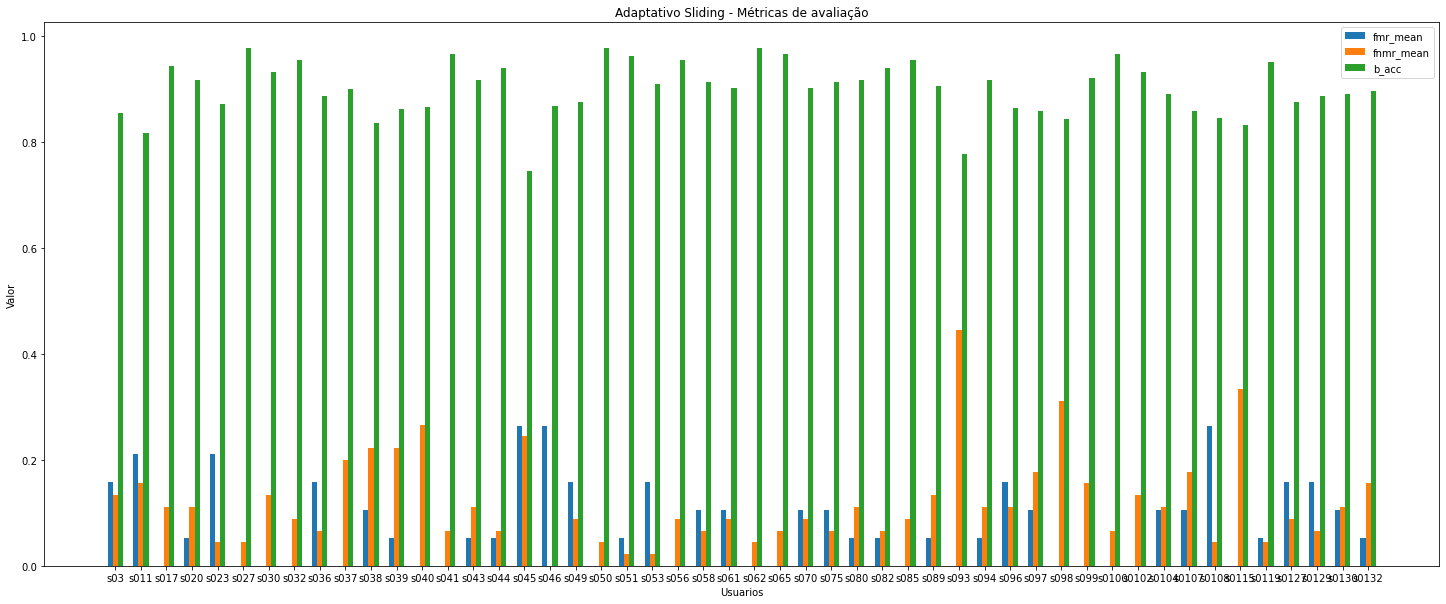

In [3]:
#SLIDING

X = metrics_adaptativo_sliding_mean['Usuarios']
fmr_mean = metrics_adaptativo_sliding_mean['fmr_mean']
fnmr_mean = metrics_adaptativo_sliding_mean['fnmr_mean']
b_acc = metrics_adaptativo_sliding_mean['b_acc_mean']

  
plt.rcParams['figure.figsize'] = [25, 10]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, fmr_mean, 0.2, label = 'fmr_mean')
plt.bar(X_axis + 0, fnmr_mean, 0.2, label = 'fnmr_mean')
plt.bar(X_axis + 0.2, b_acc, 0.2, label = 'b_acc')

plt.xticks(X_axis, X)
plt.xlabel("Usuarios")
plt.ylabel("Valor")
plt.title("Adaptativo Sliding - Métricas de avaliação")
plt.legend()
plt.show()

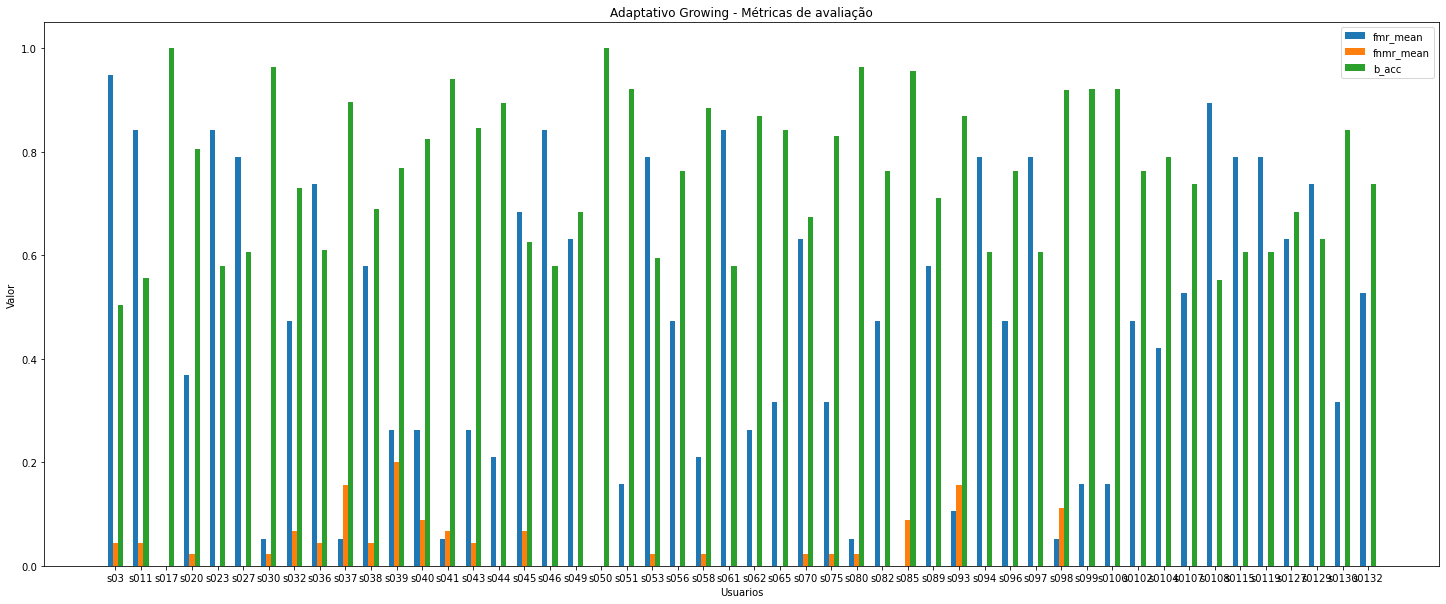

In [4]:
#GROWING
X = metrics_adaptativo_growing_mean['Usuarios']
fmr_mean = metrics_adaptativo_growing_mean['fmr_mean']
fnmr_mean = metrics_adaptativo_growing_mean['fnmr_mean']
b_acc = metrics_adaptativo_growing_mean['b_acc_mean']

  
plt.rcParams['figure.figsize'] = [25, 10]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, fmr_mean, 0.2, label = 'fmr_mean')
plt.bar(X_axis + 0, fnmr_mean, 0.2, label = 'fnmr_mean')
plt.bar(X_axis + 0.2, b_acc, 0.2, label = 'b_acc')

plt.xticks(X_axis, X)
plt.xlabel("Usuarios")
plt.ylabel("Valor")
plt.title("Adaptativo Growing - Métricas de avaliação")
plt.legend()
plt.show()


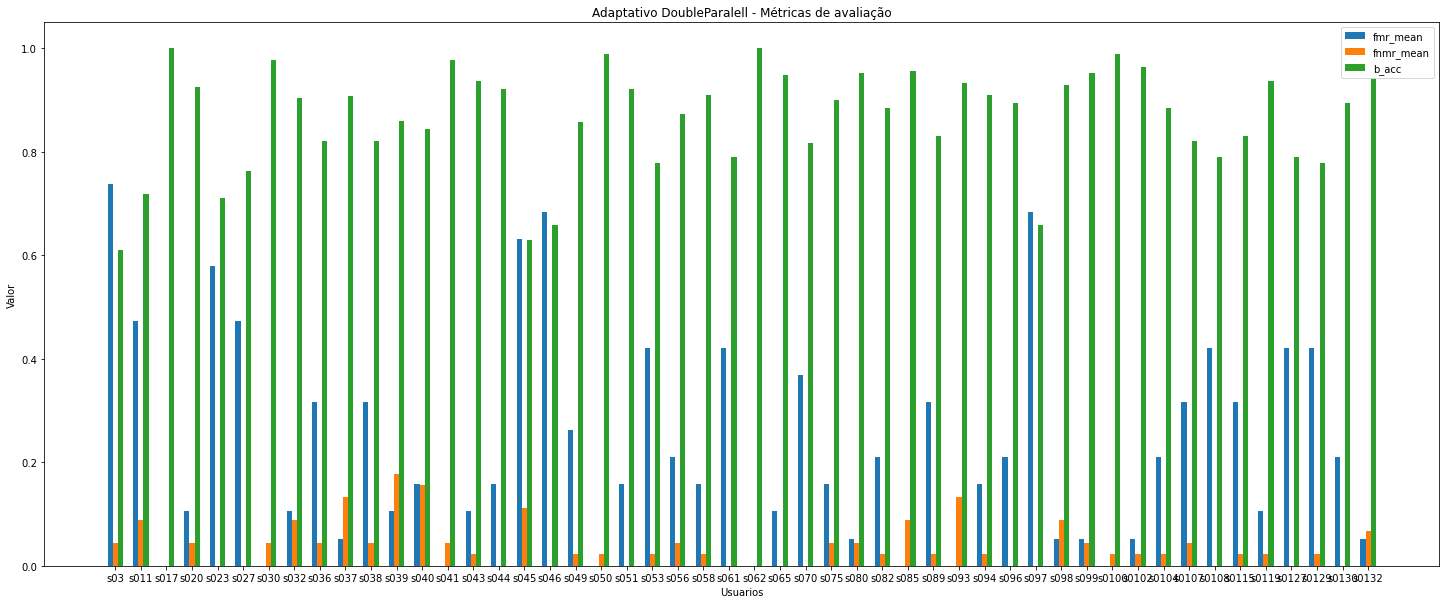

In [5]:
#DoubleParallel

X = metrics_adaptativo_double_mean['Usuarios']
fmr_mean = metrics_adaptativo_double_mean['fmr_mean']
fnmr_mean = metrics_adaptativo_double_mean['fnmr_mean']
b_acc = metrics_adaptativo_double_mean['b_acc_mean']

  
plt.rcParams['figure.figsize'] = [25, 10]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, fmr_mean, 0.2, label = 'fmr_mean')
plt.bar(X_axis + 0, fnmr_mean, 0.2, label = 'fnmr_mean')
plt.bar(X_axis + 0.2, b_acc, 0.2, label = 'b_acc')

plt.xticks(X_axis, X)
plt.xlabel("Usuarios")
plt.ylabel("Valor")
plt.title("Adaptativo DoubleParalell - Métricas de avaliação")
plt.legend()
plt.show()